### Here, we combine the training data from the four states WI, MA, GA and NC and create a combined model
- We consider the OLS linear regression, Adaboost, Random forest and xgboost models.
- We also perform some hyperparameter tuning on the xgboost model.
- The best hyperparameters: n_estimators = 1000, max_depth = 3 and learning_rate = 0.05
- We do PCA with n-components=0.95 to this hyperparameter tuned model to create another model.
### Summarizing RMSE's on 5-Fold cross-validation of the various models:
- Baseline ("take average and call it a day" model): 19.435566170780614
- OLS linear regression (sklearn): 14.559055991158607
- Adaboost model (sklearn): 12.906395048789772
- Random forest model (sklearn): 10.953117282796535
- Xgboost model (w/o hyperparameter tuning): 10.699680617050998
- Xgboost model (with hyperparameter tuning): 10.381850664670418
- Xgboost model (hyperparameter tuning + PCA): 10.65260641649726
### Summarizing R-squared score on 5-fold cross-validation of the various models
- Baseline ("take average and call it a day" model): -0.0039697246545322695
- OLS linear regression (sklearn): 0.43643944317214933
- Adaboost model (sklearn): 0.5571093080817437
- Random forest model (sklearn): 0.6807484011328917
- Xgboost model (w/o hyperparameter tuning): 0.695064708859438
- Xgboost model (with hyperparameter tuning): 0.7129848125658172
- Xgboost model (hyperparameter tuning + PCA): 0.6981785958463579

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
wi_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
ma_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
ga_training = pd.read_pickle('data/GA_pickled/training.pkl')
nc_training = pd.read_csv('data/North_Carolina/train_test_split/training.csv')

In [3]:
features = list(wi_training.columns[9:])
relevantcolumns = ['COUNTY','PERCENT_3_OR_ABOVE']+features
len(relevantcolumns)

19

In [4]:
ga_training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'},inplace=True)

In [5]:
nc_training.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [6]:
wi_training=wi_training[relevantcolumns]
ma_training=ma_training[relevantcolumns]
ga_training=ga_training[relevantcolumns]
nc_training=nc_training[relevantcolumns]

In [7]:
nc_training=nc_training[nc_training['PERCENT_3_OR_ABOVE'] != '*']

In [8]:
nc_training=nc_training.dropna()

In [9]:
training = pd.concat([wi_training,ma_training,ga_training,nc_training],axis=0)

In [10]:
training = training.apply(pd.to_numeric, errors='coerce')

In [11]:
training

,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,NaN,58.508604,65586.0,52266.0,102.934660,49.119866,54.126134,149.798787,93.728419,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,NaN,42.187500,16631.0,42307.0,93.067423,37.142154,30.704517,165.243556,91.579850,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,NaN,59.333333,23688.0,49996.0,96.378027,36.954639,42.626467,159.078732,94.292621,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,NaN,75.934136,90998.0,83681.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,NaN,68.906752,91613.0,86875.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,70.000000,19383.0,54915.0,137.926921,28.720862,37.577446,183.704575,137.926921,30033.8,5018.6,1433.2,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8
224,NaN,69.512195,33046.0,48333.0,131.307585,38.818306,40.054315,178.329454,131.307585,30916.8,6888.4,2391.2,24107.2,30916.8,6860.6,910.4,1802.2,6481.0,6860.6
227,NaN,65.241295,227214.0,49313.0,91.741941,29.883256,24.596159,183.714823,91.741941,22496.4,15354.6,872.0,24885.2,22496.4,6242.6,1207.8,524.6,6909.0,6242.6
228,NaN,56.060606,99799.0,40777.0,129.024685,33.206873,39.224774,197.321227,129.024685,25475.8,4846.0,2406.8,24107.2,25475.8,5874.8,0.0,835.4,6481.0,5874.8


In [12]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [13]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

N_CORES = joblib.cpu_count(only_physical_cores=True)

In [ ]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(train_data[features], train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], ada_reg.predict(holdout_data[features]))
    rsquared[1, i] = ada_reg.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Foret model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))

    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    full_lr.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[4, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], full_lr.predict(holdout_data[features]))
    rsquared[4, i] = full_lr.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    

    i = i+1


[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358
[0]	train-rmse:16.07849	validation-rmse:16.27813
[10]	train-rmse:7.82496	validation-rmse:11.26908
[20]	train-rmse:6.76132	validation-rmse:10.80602
[30]	train-rm

In [52]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[1,:])}")

Baseline Avg. CV RMSE: 19.435566170780614 and STD: 0.28983035684433756
Adaboost model Avg. CV RMSE: 12.906395048789772 and STD: 0.4282853711378811
xgboost model Avg. CV RMSE: 10.699680617050998 and STD: 0.5275075418050919
Random forest model Avg. CV RMSE: 10.953117282796535 and STD: 0.4756653725105333
fullmodel Avg. CV RMSE: 14.559055991158607 and STD: 0.4282853711378811


In [53]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[4,:])} and STD: {np.std(rsquared[1,:])}")

Baseline Avg. CV score: -0.0039697246545322695 and STD: 0.005332962004680793
Adaboost Avg. CV score: 0.5571093080817437 and STD: 0.022415697948725076
Xgboost model Avg. CV score: 0.695064708859438 and STD: 0.028113712661615817
Random forest model Avg. CV score: 0.6807484011328917 and STD: 0.024339603398400467
fullmodel Avg. CV score: 0.43643944317214933 and STD: 0.022415697948725076


### Xgboost works the best on the combined model. But random forest is not far behind.

In [74]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [75]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 800

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_old_model = xgb.train(
params=params,
dtrain=dtrain_reg,
num_boost_round=n,
evals=evals,
verbose_eval=10,            # Print rmse val every 10 rounds
early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)
## This model is created before any hyperparameters tuning. So we name it as 'xgb_old_model'

[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358


# Hyperparameters tuning for xgboost model

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer

transformer = ColumnTransformer(transformers=[
    ('freq',PowerTransformer(method='box-cox', standardize=False),[0]),
    ('chord', KBinsDiscretizer(n_bins = 6, encode='ordinal', strategy='kmeans'),[1] ),
    ('vel',KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='kmeans'),[2]),
    ('thickness',QuantileTransformer(),[3]),
    ],
    remainder='passthrough'
    )


In [45]:

hyperparameter_grid = {
    'model__n_estimators': [100, 400, 800, 1000],
    'model__max_depth': [3, 6, 9, 10],
    'model__learning_rate': [0.01,0.05, 0.1, 0.20],
    }

pipeline = RandomizedSearchCV(
    Pipeline(steps=[("preprocessor", transformer), 
                    ("model", xgb.XGBRegressor(objective= 'reg:squarederror',seed = 0))
                    ]),
    param_distributions=hyperparameter_grid,
    n_iter=20,
    scoring='r2',
    n_jobs=-1,
    cv=7,
    verbose=3)


In [46]:
pipeline.fit(X_train, y_train)

Fitting 7 folds for each of 20 candidates, totalling 140 fits
[CV 1/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.476 total time=   0.6s
[CV 2/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.456 total time=   0.5s
[CV 3/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.537 total time=   0.4s
[CV 4/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.509 total time=   0.5s
[CV 5/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.504 total time=   0.6s
[CV 6/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.572 total time=   0.5s
[CV 7/7] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=400;, score=0.536 total time=   0.5s
[CV 6/7] END model__learning_rate=0.1, model__max_depth=9, model__n_estimators=1000;, score=0.774 total time=   4.5s
[C

RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('freq',
                                                                               PowerTransformer(method='box-cox',
                                                                                                standardize=False),
                                                                               [0]),
                                                                              ('chord',
                                                                               KBinsDiscretizer(encode='ordinal',
                                                                                                n_bins=6,
                                                                                                strategy='kmeans'),
                                                                               [1]),
                                                                              ('vel',
                                                                               KBinsDiscretizer(encode='ordinal',
                                                                                                n_bins=4,
                                                                                                strategy='kmeans'),
                                                                               [2]),
                                                                              ('thickness'...
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2],
                                        'model__max_depth': [3, 6, 9, 10],
                                        'model__n_estimators': [100, 400, 800,
                                                                1000]},
                   scoring='r2', verbose=3)

In [47]:
hyperparam = pipeline.best_params_
print("The best Hyperparameters for XGBRegressor are: {}".format(hyperparam))

The best Hyperparameters for XGBRegressor are: {'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.05}


# Next, let us see if PCA makes our model more efficient or if we drastically lose performance.

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [64]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(train[features])
training_scaled.shape

(1373, 17)

In [65]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)
training_pca.shape

(1373, 9)

In [66]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('xgb_model', xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror'))])

In [67]:
xgb_pca_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [77]:
xgb_pca_preds = xgb_pca_pipe.predict(validation[features])
print(root_mean_squared_error(xgb_pca_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(xgb_pca_preds,validation['PERCENT_3_OR_ABOVE']))

11.341547079563247
0.45631798570171367


In [79]:
xgb_preds = xgb_model.predict(validation[features])
print(root_mean_squared_error(xgb_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(xgb_preds,validation['PERCENT_3_OR_ABOVE']))

10.67083332636807
0.5486115567672252


In [80]:
xgb_old_preds = xgb_old_model.predict(dtest_reg)
print(root_mean_squared_error(xgb_old_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(xgb_old_preds,validation['PERCENT_3_OR_ABOVE']))

11.315453848208739
0.5618774649296763


### Our hyperparameter-tuned model is clearly better than the older model in terms of root mean squared error and the PCA(0.95) model is only marginally behind our old model. On the other hand, in terms of R-squared coefficient, our old model is performing marginally better than the hyperparameter-tuned model.
### Let us further test with 5-Fold cross validation.

In [88]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for new hyperparameter tuned xgboost model
    xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror')
    xgb_model.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_model.predict(holdout_data[features]))
    rsquared[1, i] = xgb_model.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for old (not hyperparameter tuned) xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_old_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_old_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for xgb PCA(0.95) model with hyperparameter tuning
    xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror'))])
    xgb_pca_pipe.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))

    

    i = i+1

[0]	train-rmse:15.85365	validation-rmse:16.81185
[10]	train-rmse:7.75098	validation-rmse:11.73022
[20]	train-rmse:6.41767	validation-rmse:11.43744
[30]	train-rmse:5.84996	validation-rmse:11.33003
[40]	train-rmse:5.50892	validation-rmse:11.26095
[50]	train-rmse:5.19658	validation-rmse:11.24787
[60]	train-rmse:5.01117	validation-rmse:11.17852
[70]	train-rmse:4.84692	validation-rmse:11.25123
[80]	train-rmse:4.74598	validation-rmse:11.26222
[90]	train-rmse:4.68982	validation-rmse:11.28030
[100]	train-rmse:4.64678	validation-rmse:11.27379
[110]	train-rmse:4.62383	validation-rmse:11.28349
[120]	train-rmse:4.60657	validation-rmse:11.28628
[130]	train-rmse:4.59390	validation-rmse:11.30134
[140]	train-rmse:4.58306	validation-rmse:11.31466
[150]	train-rmse:4.57597	validation-rmse:11.31169
[159]	train-rmse:4.57336	validation-rmse:11.31358
[0]	train-rmse:16.07849	validation-rmse:16.27813
[10]	train-rmse:7.82496	validation-rmse:11.26908
[20]	train-rmse:6.76132	validation-rmse:10.80602
[30]	train-rm

In [89]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"Old xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.435566170780614 and STD: 0.28983035684433756
Hyperparameter tuned xgboost model Avg. CV RMSE: 10.381850664670418 and STD: 0.4869576118473383
Old xgboost model Avg. CV RMSE: 10.699680617050998 and STD: 0.5275075418050919
Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: 10.65260641649726 and STD: 0.4233466773691271


In [90]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Old Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.0039697246545322695 and STD: 0.005332962004680793
Hyperparameter tuned xgboost model Avg. CV score: 0.7129848125658172 and STD: 0.025071772193848905
Old Xgboost model Avg. CV score: 0.695064708859438 and STD: 0.028113712661615817
Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: 0.6981785958463579 and STD: 0.019754265977801784


### The hyperparameter tuned model is certainly the beest. But PCA(0.95) does not fall behind in performance by much.

### We save our new hyperparameters tuned xgboost model as a pickle file. This will serve as our final model for four states combined.

In [91]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror')
xgb_model.fit(train[features],train['PERCENT_3_OR_ABOVE'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [92]:
import joblib
from joblib import Parallel, delayed

## Save the xgboost model as a pickled file.

joblib.dump(xgb_model, 'data/four_states_combined_xgboost_model.pkl')

['data/four_states_combined_xgboost_model.pkl']

In [93]:
import shap

In [94]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

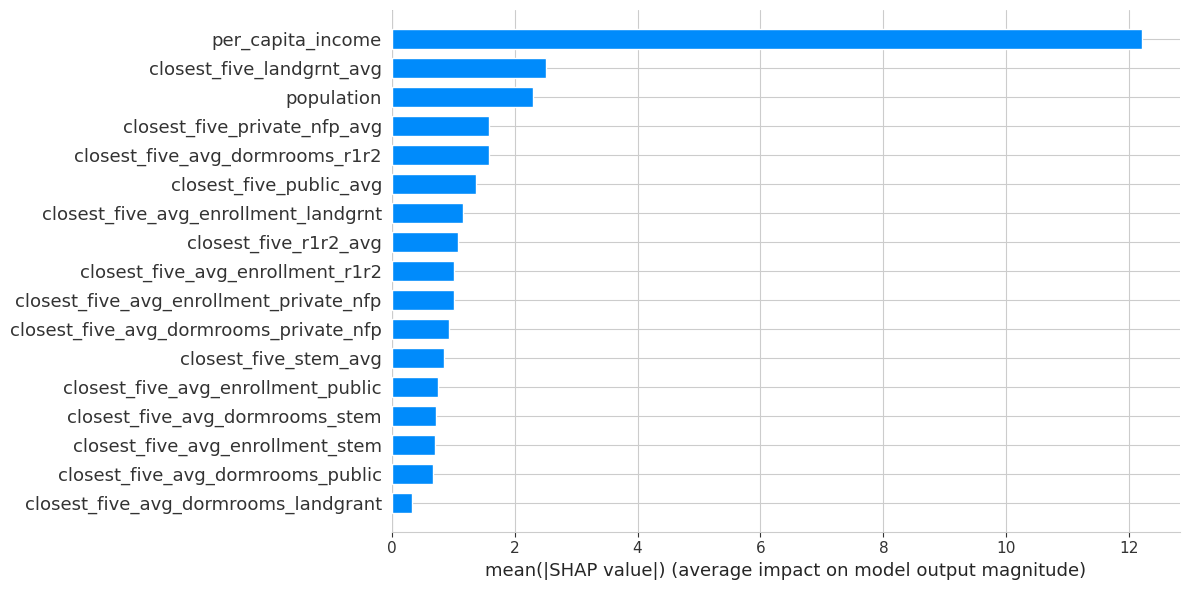

In [95]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

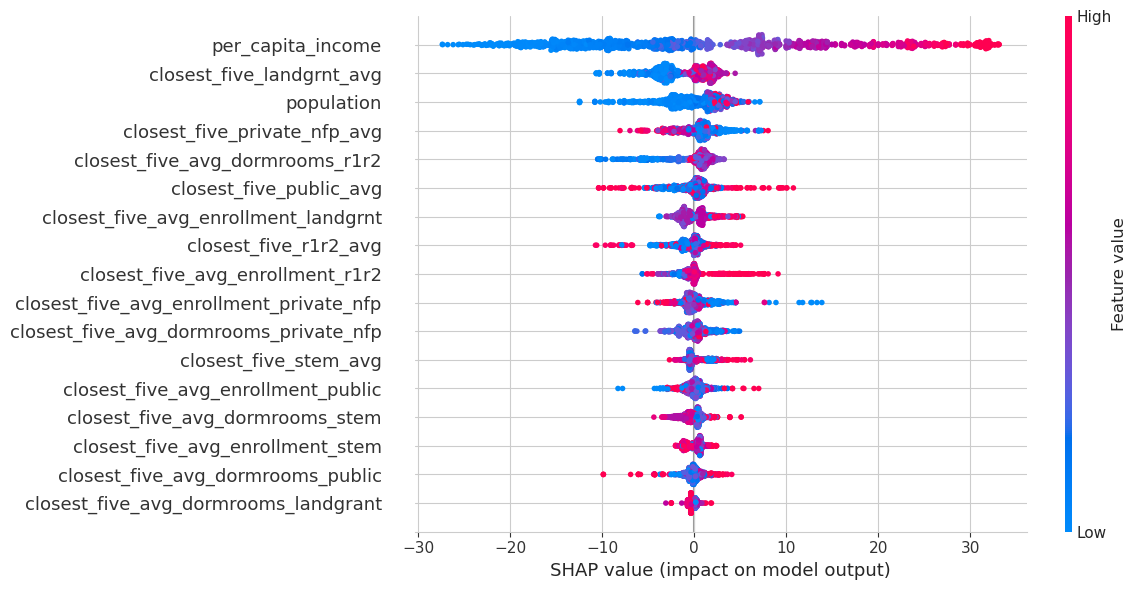

In [96]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()